# Attempted Simplification of Existing Mountain Car [Example](https://reactivebayes.github.io/RxInfer.jl/stable/examples/advanced_examples/Active%20Inference%20Mountain%20car/#examples-active-inference-mountain-car) 

In what follows, I have attempted to re-create the existing Mountain Car example from the set of "advanced" examples found in the RxInfer documentation. The specific Mountain Car example can be found [here](https://reactivebayes.github.io/RxInfer.jl/stable/examples/advanced_examples/Active%20Inference%20Mountain%20car/#examples-active-inference-mountain-car). 

My motivation with this "re-implementation" of the Mountain Car example is twofld. First, the existing implementation is perhaps a little "bloated". My aesthetic sense is that it would be nice to have a simpler instantiation of the same example. Second, I am interested in integrating the Mountain Car agent, defined via RxInfer, with the Mountain Car environment defined by [RxEnvironments](https://biaslab.github.io/RxEnvironments.jl/stable/lib/example_mountaincar/#lib-mountain-car). Regarding this latter end, it is not all that obvious how to "marry up" the existing RxInfer Mountain Car agent witht the new RxEnvironments environment specification, especially in light of the "imperative-like" specification of the exsiting implementation's 6 methods for control flow. 

My own approach has also ben twofold. First, I have taken the agent/environment specification of the agent and the environment, directly from the [RxEnvironments](https://biaslab.github.io/RxEnvironments.jl/stable/lib/example_mountaincar/#lib-mountain-car) example. This seemed like a natural choice, since I want to integrate this with RxEnvironments anyway. Secondly, I have tried model the agent's internal structure and the subequent inference process after the existing [drone navigation example](https://github.com/ReactiveBayes/RxInferExamples.jl/tree/main). 

The implementation of the RxInfer drone navigation example is much simpler than that of the existing Mountain Car example in RxInfer. It therefore seemed to be another natural choice of agent-specification for a "simplified" Mountain Car agent. Specifically, the approach emboied in the [drone navigation example](https://github.com/ReactiveBayes/RxInferExamples.jl/tree/main) example seems - to me - to offer a potential standardisation of the agent-specification procedure in RxInfer. This is due to its use of the following very general functions:

1. ```state_transition```, which specifies our assumptions about how the agent's internal states evolve with time. 
2. The agent's probabilistic model function (by means of the ```@model``` macro). 
3. ```move_to_target```, which handles the "main loop" of the inference procedure. 

I have attempted to run this simplified Mountain Car RxInfer agent, only to be met with several cryptic errors. I'm sure they are only "cryptic" to me and not in any unqualified sense. 

# General Notes - Wouter's Feedback:

The [drone example](https://github.com/ReactiveBayes/RxInferExamples.jl/tree/main/drone) - and hence this mountain car model - is not actually doing control. Instead, it's returning the agent's (internal) "plan" of motor actions, without ever actually "excecuting" this plan in the (external) environment. This is helpful for didactic purposes - since in the [drone example](https://github.com/ReactiveBayes/RxInferExamples.jl/tree/main/drone), the plan and the resultant dynamics with control are basically isomorphic - but not for a more general simulation framework. We'd like to be more "hygenic" and clearly deliniate the agent's beliefs about state tranaitions, from the "actual state transitions".  

The reason why the present Mountain Car simualtion has so many disconnected components, is due to the fact that nowhere in the present model definiton is there a specified relationship between "s[i]" and "s[i+1]". At present, the relevant place in our model definition is:

```julia
# state transition
next_state = state_transition(car, environment, dt) # the current state must be passed in somehow!
s[i + 1] ~ MvNormal(
    mean = next_state, 
    covariance = 1e-10 * [1.0 0.0; 0.0 1.0]
) # there is no specified "link" between s[i] and s[i + 1]. This results in disconnected graph components
```

Whereas the [drone example](https://github.com/ReactiveBayes/RxInferExamples.jl/tree/main/drone) has:

```julia
# state transition
s[i + 1] ~ MvNormal(
    μ = state_transition(s[i], u[i], drone, environment, dt), # s[i + 1] is specified as dependent on s[i]
    Σ = 1e-10 * I
)
```

Must I pass ```state(car)``` inside the ```car``` struct, when passing the ```car``` struct to the ```state_transition``` function then? Can I get away with only passing the car's "state": ```state(car)``` to the ```state_transition``` function?


Might need to use ```:=``` instead of ```=``` in the following?

```julia
next_state := state_transition(car, environment, dt)
```

See the docs on the [this operator](https://reactivebayes.github.io/GraphPPL.jl/stable/syntax_guide/#The-:-operator). 

In [1]:
using Pkg; Pkg.activate("."); Pkg.instantiate()

  Activating project at `~/Desktop/Active_Inference_Institute/RxInfer_Group/Simplified_Mountain_Car`


In [2]:
import HypergeometricFunctions: _₂F₁
using RxInfer
using Plots
using GraphPlot
using Distributions
using ForwardDiff
using DifferentialEquations
using LinearAlgebra
using MetaGraphsNext
using Debugger
using Compose

using Cairo
using Fontconfig

# Setup

The following defines a generic landscape function to use as the "mountain". Note that the environment will also work with other (differentiable) landscape functions.

In [3]:
function landscape(x)
    if x < 0
        h = x^2 + x
    else
        h =
            x * _₂F₁(0.5, 0.5, 1.5, -5 * x^2) +
            x^3 * _₂F₁(1.5, 1.5, 2.5, -5 * x^2) / 3 +
            x^5 / 80
    end
    return 0.05 * h
end

landscape (generic function with 1 method)

### Visualising the Landscape Function:

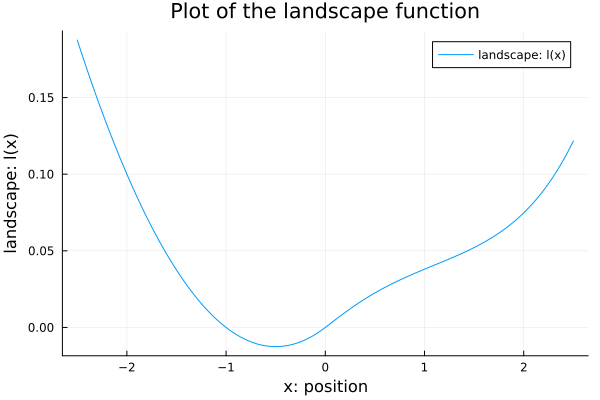

In [4]:
# Create the domain
x_values = -2.5:0.01:2.5

# Evaluate the range of the function
y_values = landscape.(x_values)

# Plot the results
plot(
    x_values, 
    y_values, 
    label = "landscape: l(x)", 
    xlabel = "x: position", 
    ylabel = "landscape: l(x)", 
    title = "Plot of the landscape function"
)

# The Agent

Everything from here until the next section is taken directly from the [existing Mountain Car example](https://biaslab.github.io/RxEnvironments.jl/stable/lib/example_mountaincar/#lib-mountain-car), in the RxEnvironments documentation.

Below, we create a structure in which we are going to store the precomputed trajectory of the mountain car:

In [5]:
mutable struct MountainCarTrajectory{T<:Real}
    time_left::T
    trajectory::Any
    T::T
end

In [6]:
# Convenient getters and setters

time_left(
    trajectory::MountainCarTrajectory
) = trajectory.time_left

current_time(
    trajectory::MountainCarTrajectory
) = total_time(trajectory) - time_left(trajectory)

total_time(
    trajectory::MountainCarTrajectory
) = trajectory.T

Base.getindex(
    trajectory::MountainCarTrajectory, 
    index
) = trajectory.trajectory(index)


set_time_left!(
    trajectory::MountainCarTrajectory, 
    time_left) = trajectory.time_left = time_left

reduce_time_left!(
    trajectory::MountainCarTrajectory, elapsed_time
) = set_time_left!(trajectory, time_left(trajectory) - elapsed_time)

reduce_time_left! (generic function with 1 method)

This trajectory is wrapped in the state of a Mountain Car, which contains all variables of the mountain car that are subject to change, such as position and velocity.

In [7]:
mutable struct MountainCarState{T<:Real}
    position::T
    velocity::T
    throttle::T
    trajectory::MountainCarTrajectory{T}
end

In [8]:
# Convenient getters and setters
position(
    state::MountainCarState
) = state.position

velocity(
    state::MountainCarState
) = state.velocity

throttle(
    state::MountainCarState
) = state.throttle

observable_state(
    state::MountainCarState
) = [position(state), velocity(state)]

set_position!(
    state::MountainCarState, position::Real
) = state.position = position

set_velocity!(
    state::MountainCarState, velocity::Real
) = state.velocity = velocity

set_throttle!(
    state::MountainCarState, throttle::Real
) = state.throttle = throttle

set_trajectory!(
    state::MountainCarState, trajectory
) = state.trajectory = trajectory

trajectory(
    state::MountainCarState
) = state.trajectory

trajectory (generic function with 1 method)

In [9]:
# This is a convenient constructor that creates an empty trajectory 
# that will immediately be replaced.
MountainCarState(
    position::Real, velocity::Real, throttle::Real
) = MountainCarState(
    position,
    velocity,
    throttle,
    MountainCarTrajectory(0.0, [], 0.0),
)

MountainCarState

The actual Mountain Car struct will contain the state of the mountain car, as well as constants such as the engine power and friction coefficient:

In [10]:
struct MountainCarAgent{T<:Real}
    state::MountainCarState{T}
    engine_power_coeff::T
    friction_coefficient::T
    mass::T
    target::T
end

In [11]:
MountainCarAgent(
    position::Real,
    engine_power_coeff::Real,
    friction_coefficient::Real,
    mass::Real,
    target::Real,
) = MountainCarAgent(
    MountainCarState(position, 0.0, 0.0),
    engine_power_coeff,
    friction_coefficient,
    mass,
    target,
)

MountainCarAgent

In [12]:
# Convenient getters and setters
state(
    car::MountainCarAgent
) = car.state

position(
    car::MountainCarAgent
) = position(state(car))
    
velocity(
    car::MountainCarAgent
) = velocity(state(car))

throttle(
    car::MountainCarAgent
) = throttle(state(car))

mass(
    car::MountainCarAgent
) = car.mass

observable_state(
    car::MountainCarAgent
) = observable_state(state(car))

get_properties(
    car::MountainCarAgent
) = (car.mass, car.engine_power_coeff, car.friction_coefficient, car.target)
    

set_position!(
    car::MountainCarAgent, position::Real
) = set_position!(state(car), position)

set_velocity!(
    car::MountainCarAgent, velocity::Real
) = set_velocity!(state(car), velocity)

set_throttle!(
    car::MountainCarAgent, throttle::Real
) = set_throttle!(state(car), throttle)

engine_power(
    car::MountainCarAgent
) = car.engine_power_coeff

friction_coefficient(
    car::MountainCarAgent
) = car.friction_coefficient

set_trajectory!(
    car::MountainCarAgent, trajectory
) = set_trajectory!(state(car), trajectory)

trajectory(
    car::MountainCarAgent
) = trajectory(state(car))
    
engine_force(
    throttle::Real, engine_power_coeff
) = throttle * engine_power_coeff
    

engine_force (generic function with 1 method)

# The Environment

We must be able to compute changes in the state dynamics at each point in time. To that end, we specify the relevant forces acting on the car - which are assumed to encode these details:

In [13]:
function gravitational_force(x_t, mass, landscape_function)
    
    slope = ForwardDiff.derivative(landscape_function, x_t)
    
    f_g = -9.81 * mass * (
        sin(
            arctan(
                slope
            )
        )
    )
    
    return f_g
end

gravitational_force (generic function with 1 method)

In [14]:
function frictional_force(car_velocity, friction_coeff)
    return -car_velocity * friction_coeff
end

frictional_force (generic function with 1 method)

Now we are in a shape where we can define the actual environment, which will contain a landscape function, the environmental physics and a Mountain Car.

In [16]:
struct MountainCarEnvironment
    agent::MountainCarAgent
    landscape::Any
    gravitational_force::Function
    frictional_force::Function
end

In [17]:
# MountainCarEnvironment(
#     landscape
# ) = MountainCarEnvironment([], landscape)

MountainCarEnvironment

# The Agent's Internal Structure

In [17]:
"""
state_transition(car::MountainCarAgent, dt::Float64)

This function computes the next state of the mountain car given the 
current state, the actions, the car properties, and the environment properties.

This is all internal to the agent - these are the result of its relevant beliefs.

TAKEN FROM/INSPIRED BY THE EXISTING DRONE NAVIGATION EXAMPLE: https://github.com/ReactiveBayes/RxInferExamples.jl/tree/main/drone
"""
function state_transition(
        car_state::MountainCarState, 
        environment::MountainCarEnvironment, 
        dt::Float64,
        mass::Real,
        engine_power_coeff::Real,
        friction_coefficient::Real
    )
    
    # Extract state properties
    pos = position(car_state)
    vel = velocity(car_state)
    throttle_input = throttle(car_state)
    
    # Compute the slope of the landscape at the current position
    slope = ForwardDiff.derivative(environment.landscape, pos)
    
    # Compute forces
    engine_force = engine_power_coeff * throttle_input
    gravity_force = -mass * 9.81 # * slope # wrong
    friction_force = -friction_coefficient * vel
    
    # Total force
    total_force = engine_force + gravity_force + friction_force
    
    # Compute acceleration
    acceleration = total_force / mass
    
    # Update velocity and position
    new_vel = vel + acceleration * dt
    new_pos = pos + vel * dt + 0.5 * acceleration * dt^2
    
    # Update state
    set_velocity!(car_state, new_vel)
    set_position!(car_state, new_pos)
    
    return [new_pos, new_vel]
end

state_transition

In [18]:
# Function for modeling engine control
function control(u::AbstractVector)
    return [0.0, Fa(u[1])] 
end

# Inverse engine force, from change in state to corresponding engine force
function inv_control(delta_s_dot::AbstractVector)
    
    engine_force_limit = 0.5 # HARDCODED
    
    return [
        atanh(clamp(delta_s_dot[2], -engine_force_limit+1e-3, 
        engine_force_limit-1e-3) / engine_force_limit)
    ]
end

inv_control (generic function with 1 method)

In [19]:
# WORKING VERSION 1
@model function mcar_model(
        car, 
        environment, 
        
        initial_state, # m_s_t_min in the existing example
        
        control_mean,  # m_u in the existing example
        control_cov,   # V_u in the existing example
        
        goal,          # m_x in the existing example
        
        horizon, 
        dt
    )

    # extract car properties
    mass, engine_power_coeff, friction_coefficient, target = get_properties(car)

    # initial state prior
    s[1] ~ MvNormal(
        mean = initial_state, 
        covariance = 1e-5 * [1.0 0.0; 0.0 1.0] # V_s_t_min
    )  # position and velocity    

    for i in 1:Int(horizon)

        # prior on throttle (control)
        u[i] ~ MvNormal(
            mean = control_mean,
            cov = control_cov
        )
        
        # control-model
        u_control[i] ~ control(u[i]) where {
            meta = DeltaMeta(
                method = Linearization(), 
                inverse = inv_control
            )
        } # same meta as in the existing example
            
        # state transition function:
        state_trans[i] := state_transition(
            s[i], environment, dt, mass, engine_power_coeff, friction_coefficient
        ) where {
            meta = DeltaMeta(
                method = Linearization()
            )
        } # same meta as in the existing example
        # THESE META SPECIFICATIONS CAN EITHER BE DONE HERE OR WITH THE @meta MACRO
        
        # additive control effect on states:
        u_s_sum[i] ~ state_trans[i] + u_control[i]

        # state model update - with additive controls:
        s[i + 1] ~ MvNormal(
            mean = u_s_sum[i],
            covariance = 1e-10 * [1.0 0.0; 0.0 1.0]
        )
        
        # observation model:
        x[i + 1] ~ MvNormal(
            mean = s[i + 1],
            covariance = 1e-10 * [1.0 0.0; 0.0 1.0]
        )
        
        # goal observation:
        x[i + 1] ~ MvNormal(
            mean = goal, # m_x
            covariance = 1e-5 * [1.0 0.0; 0.0 1.0] # V_x
        )  # goal for position and velocity
        
    end

    s[end] ~ MvNormal(mean = goal, covariance = 1e-5 * [1.0 0.0; 0.0 1.0])  # goal for position and velocity

end

## Probabilistic inference

In [20]:
# TAKEN FROM/INSPIRED BY THE EXISTING DRONE NAVIGATION EXAMPLE: 
# https://github.com/ReactiveBayes/RxInferExamples.jl/tree/main/drone

function move_to_target(
        car::MountainCarAgent, 
        env::MountainCarEnvironment, 
        start::MountainCarState, 
        control_mean,
        control_cov,
        target, 
        horizon,
        dt
    )

    results = infer(
        
        model = mcar_model(
            car = car,
            environment = env,
            horizon = horizon,
            dt = dt
        ),
        
        data  = (
            initial_state = [position(start), velocity(start)],
#             goal = [target[1], target[2]]
            goal = target,
            control_mean,  # m_u
            control_cov,   # V_u
        ),

        returnvars = (
            s = KeepLast(), 
            u = KeepLast()
        )
    )

    return results

end

move_to_target (generic function with 1 method)

In [21]:
# TAKEN FROM/INSPIRED BY THE EXISTING DRONE NAVIGATION EXAMPLE: 
# https://github.com/ReactiveBayes/RxInferExamples.jl/tree/main/drone

time_horizon = 100.0 # CHANGE THIS TO 100
# time_horizon = 100

start = MountainCarState(
    -0.5, # T
    0.0, # T
    0.0, # T
    MountainCarTrajectory(
        time_horizon,
        [],
        time_horizon
    )
)

# target = [0.5, 0.0] 
target = 0.5

mcar_agent = MountainCarAgent(
    start, # MountainCarState{T}
    0.5, # T
    0.1, # T
    0.2, # T
    target # T
)

mcar_env = MountainCarEnvironment(
    mcar_agent,
    landscape,
    gravitational_force,
    frictional_force
)

MountainCarEnvironment(MountainCarAgent{Float64}(MountainCarState{Float64}(-0.5, 0.0, 0.0, MountainCarTrajectory{Float64}(100.0, Any[], 100.0)), 0.5, 0.1, 0.2, 0.5), landscape, gravitational_force, frictional_force)

In [22]:
Epsilon = fill(huge, 1, 1)                # Control prior variance

my_mcar_model = mcar_model(
    car = mcar_agent,
    environment = mcar_env,
    initial_state = [position(start), velocity(start)],
    control_mean = Vector{Float64}[ [ 0.0] for k=1:Int(time_horizon)],
    control_cov = Matrix{Float64}[ Epsilon for k=1:Int(time_horizon)],
    goal = target,
    horizon = time_horizon,
    dt = 0.05
);

In [23]:
model = GraphPPL.create_model(
    my_mcar_model
);

In [24]:
meta_graph = model.graph;

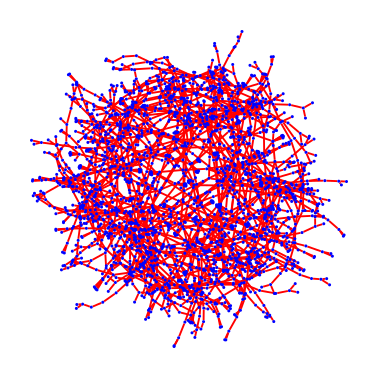

In [25]:
layout=(args...)->spring_layout(args...; C=3)

GraphPlot.gplot(
    meta_graph,
    layout=layout,
    NODESIZE=0.01, # diameter of the nodes,
#     nodelabel=collect(labels(meta_graph)),
#     NODELABELSIZE=1.0,
#     nodelabelc="cyan",
#     nodelabeldist=0.0,
    nodefillc="blue",
    EDGELINEWIDTH = 0.5,
    edgestrokec="red"
)

In [26]:
layout=(args...)->spring_layout(args...; C=2)

draw(
    PDF(
        "working_meta_graph.pdf", 30cm, 30cm
    ), GraphPlot.gplot(
        meta_graph,
        layout=layout,
        NODESIZE=0.005, # diameter of the nodes,
        nodelabel=collect(labels(meta_graph)),
        nodelabeldist=5.0,
        NODELABELSIZE=1.0,
        nodelabelc="black",
        nodefillc="blue",
        EDGELINEWIDTH = 0.5,
        edgestrokec="red"
    )
)

In [27]:
MetaGraphsNext.is_connected(meta_graph)

true

# Final Simulation:

In [28]:
Epsilon = fill(huge, 1, 1)                # Control prior variance
control_mean = Vector{Float64}[ [ 0.0] for k = 1:Int(time_horizon)] # Set control priors
control_cov = Matrix{Float64}[ Epsilon for k = 1:Int(time_horizon)];

# control_mean = Vector{Float64}[ [ 0.0] ] # Set control priors
# control_cov = Matrix{Float64}[ Epsilon ];

In [29]:
# TAKEN FROM/INSPIRED BY THE EXISTING DRONE NAVIGATION EXAMPLE: 
# https://github.com/ReactiveBayes/RxInferExamples.jl/tree/main/drone

results = move_to_target(
    mcar_agent, 
    mcar_env, 
    start, 
    control_mean,
    control_cov,
    target, 
    time_horizon, 
    0.05
)

LoadError: UndefRefError: access to undefined reference

# Leftovers

## @model

In [ ]:
# # WORKING VERSION 0
# @model function mcar_model(
#         car, 
#         environment, 
#         initial_state, 
#         goal, 
#         horizon, 
#         dt
#     )

#     # extract car properties
#     mass, engine_power_coeff, friction_coefficient, target = get_properties(car)

#     # initial state prior
#     s[1] ~ MvNormal(mean = initial_state, covariance = 1e-5 * [1.0 0.0; 0.0 1.0])  # position and velocity    

#     for i in 1:Int(horizon)

#         # prior on throttle (actions)
#         u[i] ~ Normal(0, 1)  # probably need to add the control to the state transition function
        
#         # results in disconnected components from the controls
#         s[i + 1] ~ MvNormal(
#             mean = state_transition(
#                 s[i], environment, dt, mass, engine_power_coeff, friction_coefficient
#             ), # result of passing state(car): 201 disconnected components
#             covariance = 1e-10 * [1.0 0.0; 0.0 1.0]
#         )
        
#     end

#     s[end] ~ MvNormal(mean = goal, covariance = 1e-5 * [1.0 0.0; 0.0 1.0])  # goal for position and velocity

# end

In [45]:
# This function specifies the mountain car agent's generative model.
# TAKEN FROM/INSPIRED BY THE EXISTING DRONE NAVIGATION EXAMPLE: 
# https://github.com/ReactiveBayes/RxInferExamples.jl/tree/main/drone


# @model function mcar_model(
#         car, 
#         environment, 
#         initial_state, 
#         goal, 
#         horizon, 
#         dt
#     )

#     # extract car properties
#     m, engine_power, friction_coefficient, target = get_properties(car)

#     # initial state prior
#     s[1] ~ MvNormal(mean = initial_state, covariance = 1e-5 * [1.0 0.0; 0.0 1.0])  # position and velocity

#     for i in 1:Int(horizon)

#         # prior on throttle (actions)
#         u[i] ~ Normal(0, 1)  # assuming throttle is scalar and normalized
        
#         s[i] = state(car) # DO THIS !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# #         s[i] := state(car) # or like this?

#         # state transition
# #         next_state = state_transition(car, environment, dt) # the current state must be passed in somehow!
#         next_state = state_transition(car, environment, dt) # perhaps like this?
# #         next_state := state_transition(car, environment, dt) # perhaps like this?
        
#         s[i + 1] ~ MvNormal(
#             mean = next_state, 
#             covariance = 1e-10 * [1.0 0.0; 0.0 1.0]
#         )
#         #=
#         The issue here is that the s[i + 1] node has no explicit connection to the s[i] node. 
#         At present, this will just create an isolated s[i + 1] with no explicit dependence on s[i],
#         thus resulting in a proliferation of disconnected components in the graph. 
        
#         might need to do this instead:
        
#             next_state := state_transition(car, environment, dt)
        
#         =#
#     end

#     s[end] ~ MvNormal(mean = goal, covariance = 1e-5 * [1.0 0.0; 0.0 1.0])  # goal for position and velocity

# end



# VERSION 2
# @model function mcar_model(
#         car, 
#         environment, 
#         initial_state, 
#         goal, 
#         horizon, 
#         dt
#     )

#     # extract car properties
#     m, engine_power, friction_coefficient, target = get_properties(car)

#     # initial state prior
#     s[1] ~ MvNormal(mean = initial_state, covariance = 1e-5 * [1.0 0.0; 0.0 1.0])  # position and velocity

#     for i in 1:Int(horizon)

#         # prior on throttle (actions)
#         u[i] ~ Normal(0, 1)  # assuming throttle is scalar and normalized
        
# #         s[i] = state(car) # DO THIS !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# #         s[i] := state(car) # or like this?

#         # state transition
# #         next_state = state_transition(car, environment, dt) # the current state must be passed in somehow!
#         next_state = state_transition(state(car), environment, dt) # perhaps like this?
# #         next_state := state_transition(car, environment, dt) # perhaps like this?
        
#         s[i + 1] ~ MvNormal(
#             mean = next_state, 
#             covariance = 1e-10 * [1.0 0.0; 0.0 1.0]
#         )
#         #=
#         The issue here is that the s[i + 1] node has no explicit connection to the s[i] node. 
#         At present, this will just create an isolated s[i + 1] with no explicit dependence on s[i],
#         thus resulting in a proliferation of disconnected components in the graph. 
        
#         might need to do this instead:
        
#             next_state := state_transition(car, environment, dt)
        
#         =#
#     end

#     s[end] ~ MvNormal(mean = goal, covariance = 1e-5 * [1.0 0.0; 0.0 1.0])  # goal for position and velocity

# end

## State-transition Function

In [46]:
# # OG VERSION:
# function state_transition(car::MountainCarAgent, environment::MountainCarEnvironment, dt::Float64)
#     # Extract car properties
#     m, engine_power, friction_coefficient, target = get_properties(car)
    
#     # Extract state properties
#     pos = position(car)
#     vel = velocity(car)
#     throttle_input = throttle(car)
    
#     # Compute the slope of the landscape at the current position
#     slope = ForwardDiff.derivative(environment.landscape, pos)
    
#     # Compute forces
#     engine_force = engine_power * throttle_input
#     gravity_force = -m * 9.81 # * slope # wrong
#     friction_force = -friction_coefficient * vel
    
#     # Total force
#     total_force = engine_force + gravity_force + friction_force
    
#     # Compute acceleration
#     acceleration = total_force / m
    
#     # Update velocity and position
#     new_vel = vel + acceleration * dt
#     new_pos = pos + vel * dt + 0.5 * acceleration * dt^2
    
#     # Update state
#     set_velocity!(state(car), new_vel)
#     set_position!(state(car), new_pos)
    
# #     return car
    
#     return [new_pos, new_vel]
# end